# lisabeta: examples for MBHB signal

## Imports

In [1]:
import os
import h5py
import itertools
import copy
import numpy as np
import scipy
import json
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm as tqdm

from astropy.cosmology import Planck15 as cosmo

In [2]:
import lisabeta
import lisabeta.pyconstants as pyconstants
import lisabeta.tools.pytools as pytools
import lisabeta.tools.pyspline as pyspline
import lisabeta.tools.pyoverlap as pyoverlap
import lisabeta.lisa.pyresponse as pyresponse
import lisabeta.lisa.snrtools as snrtools
import lisabeta.lisa.pyLISAnoise as pyLISAnoise
import lisabeta.lisa.lisatools as lisatools
import lisabeta.lisa.lisa as lisa
import lisabeta.lisa.lisa_fisher as lisa_fisher
import lisabeta.utils.plotutils as plotutils

/Users/marsat/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/waveforms/bbh/lalsim_wrap.py:10: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


lal.MSUN_SI != Msun


In [3]:
np.set_printoptions(legacy='1.25')
%matplotlib inline

# Fisher sky localization

In [104]:
params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(z).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [6]:
# Parameters for the waveform generation and other options

waveform_params = {
    # Frequency range
    "minf": 1e-5,
    "maxf": 0.5,
    # Reference epoch of coalescence, yr -- coalescence is at t0*yr + Deltat*s, Deltat in params
    "t0": 0.0,
    # Always cut signals timetomerger_max*yr before merger -- to avoid needlessly long signals using minf
    "timetomerger_max": 2.0,
    # Option to cut the signal pre-merger -- must be in L-frame
    "DeltatL_cut": None,
    # Further options to cut signals
    "fstart22": None,
    "fend22": None,
    "tmin": None,
    "tmax": None,
    # TDI channels to generate
    "TDI": "TDIAET",
    # Internal accuracy params
    "order_fresnel": 0,
    # Waveform approximant and set of harmonics to use
    "approximant": "IMRPhenomXHM",
    "modes": None,
    # LISA response options
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    # Noise options -- can also be given as a numpy array for interpolation
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 4.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

In [105]:
list_params = ['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi']

# Use frequency grid adjusted to inspiral phasing at low frequencies, logarithmic at high frequencies, with default number of points
freqs = ['nyquist_log', None]

# Do the computation in the L-frame
Lframe = True

steps = lisa_fisher.get_default_steps_smbh(params['M'])

fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=freqs, steps=steps, list_params=list_params, Lframe=Lframe, **waveform_params)

In [107]:
lisatools.sky_area_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)

14.660282964476014

In [121]:
lisatools.error_volume_cov(fishercov, sq_deg=True, n_sigma=None, prob=0.90)

7481.551405839143

# Sky multimodality: a simple measure

In [110]:
skymodes = [(1,0), (-1,0), (1,1), (-1,1), (1,2), (-1,2), (1,3), (-1,3)]

In [108]:
likelihood = lisa.LikelihoodLISASMBH(params, **waveform_params)

In [109]:
lisatools.func_loglikelihood_skymodes(likelihood)

{(1, 0): -2.3283064365386963e-10,
 (-1, 0): -1.2197428061626852,
 (1, 1): -533.7968161312165,
 (-1, 1): -534.3391834110953,
 (1, 2): -1061.9610051735071,
 (-1, 2): -1059.7861311220913,
 (1, 3): -534.4395742332563,
 (-1, 3): -534.9276103643933}

In [119]:
maxf_vals = np.geomspace(1e-4, 1e-2, 100)

snr_vals = np.zeros_like(maxf_vals)
lnL_skymodes_vals = {}
for skymode in skymodes:
    lnL_skymodes_vals[skymode] = np.zeros_like(maxf_vals)
for i,maxf in enumerate(tqdm(maxf_vals)):
    waveform_params_maxf = copy.deepcopy(waveform_params)
    waveform_params_maxf['maxf'] = maxf
    likelihood = lisa.LikelihoodLISASMBH(params, **waveform_params_maxf)
    snr_vals[i] = likelihood.tdisignal_inj['SNR']
    lnL_skymodes = lisatools.func_loglikelihood_skymodes(likelihood)
    for skymode in skymodes:
        lnL_skymodes_vals[skymode][i] = lnL_skymodes[skymode]

100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.24it/s]


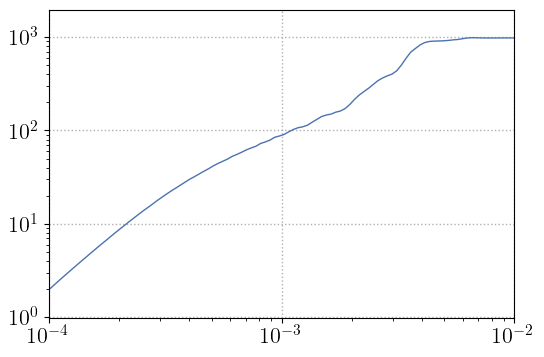

<Figure size 800x400 with 0 Axes>

In [120]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lloglogplot(ax, [maxf_vals, snr_vals])

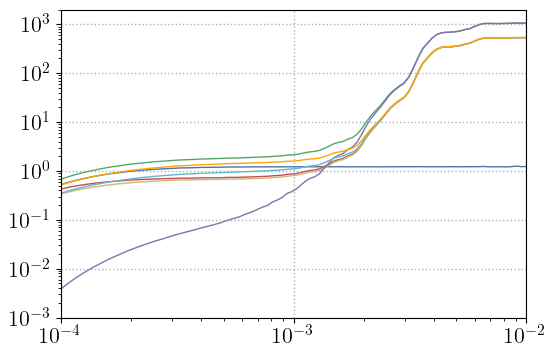

<Figure size 800x400 with 0 Axes>

In [117]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
plotutils.lloglogplot(ax, *[[maxf_vals, -lnL_skymodes_vals[skymode]] for skymode in skymodes[1:]], rangey=[1e-3, 2e3])

# Multimodality: Bayesian parameter estimation

## Setting parameters

In [4]:
# Redshift z=4
cosmo.luminosity_distance(6.).value

59046.10457286159

In [5]:
# Physical signal parameters

z = 6.

params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(z).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [6]:
# Parameters for the waveform generation and other options

waveform_params = {
    # Frequency range
    "minf": 1e-5,
    "maxf": 0.5,
    # Reference epoch of coalescence, yr -- coalescence is at t0*yr + Deltat*s, Deltat in params
    "t0": 0.0,
    # Always cut signals timetomerger_max*yr before merger -- to avoid needlessly long signals using minf
    "timetomerger_max": 2.0,
    # Option to cut the signal pre-merger -- must be in L-frame
    "DeltatL_cut": None,
    # Further options to cut signals
    "fstart22": None,
    "fend22": None,
    "tmin": None,
    "tmax": None,
    # TDI channels to generate
    "TDI": "TDIAET",
    # Internal accuracy params
    "order_fresnel": 0,
    # Waveform approximant and set of harmonics to use
    "approximant": "IMRPhenomXHM",
    "modes": None,
    # LISA response options
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    # Noise options -- can also be given as a numpy array for interpolation
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 4.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

## PE results

In [22]:
subsdir = '/Users/marsat/Projects/tutorials/lisabeta_sky_tutorial/lisabeta_sky_tutorial/example_pe/'
datadir = '/Users/marsat/Projects/tutorials/lisabeta_sky_tutorial/lisabeta_sky_tutorial/example_pe/'

In [23]:
subfile = subsdir + 'mbhb_pe_example.json'
postfile = datadir + 'mbhb_pe_example.h5'

params_post = plotutils.load_params_posterior_lisa_smbh(subfile, postfile)

post_raw_file = datadir + 'mbhb_pe_example_raw.h5'

post_raw = {}
with h5py.File(post_raw_file, 'r') as hf:
    for p in params_post['prior_params']['infer_params']:
        post_raw[p] = hf[p][:]
    post_raw['lnL'] = hf['lnlike'][:]

In [24]:
params_post.keys()

dict_keys(['fishercov', 'injparams_SSBframe', 'injparams_Lframe', 'waveform_params', 'prior_params', 'run_params', 'post'])

In [25]:
params_post['prior_params']['infer_params']

['Mchirp',
 'q',
 'chip',
 'chim',
 'Deltat',
 'dist',
 'inc',
 'phi',
 'lambda',
 'beta',
 'psi']

In [26]:
params_post['post'].keys()

dict_keys(['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi', 'lnL', 'lnpost', 'Lframe', 'm1', 'm2', 'M', 'eta', 'chi1', 'chi2', 'chis', 'chia', 'chiPN'])

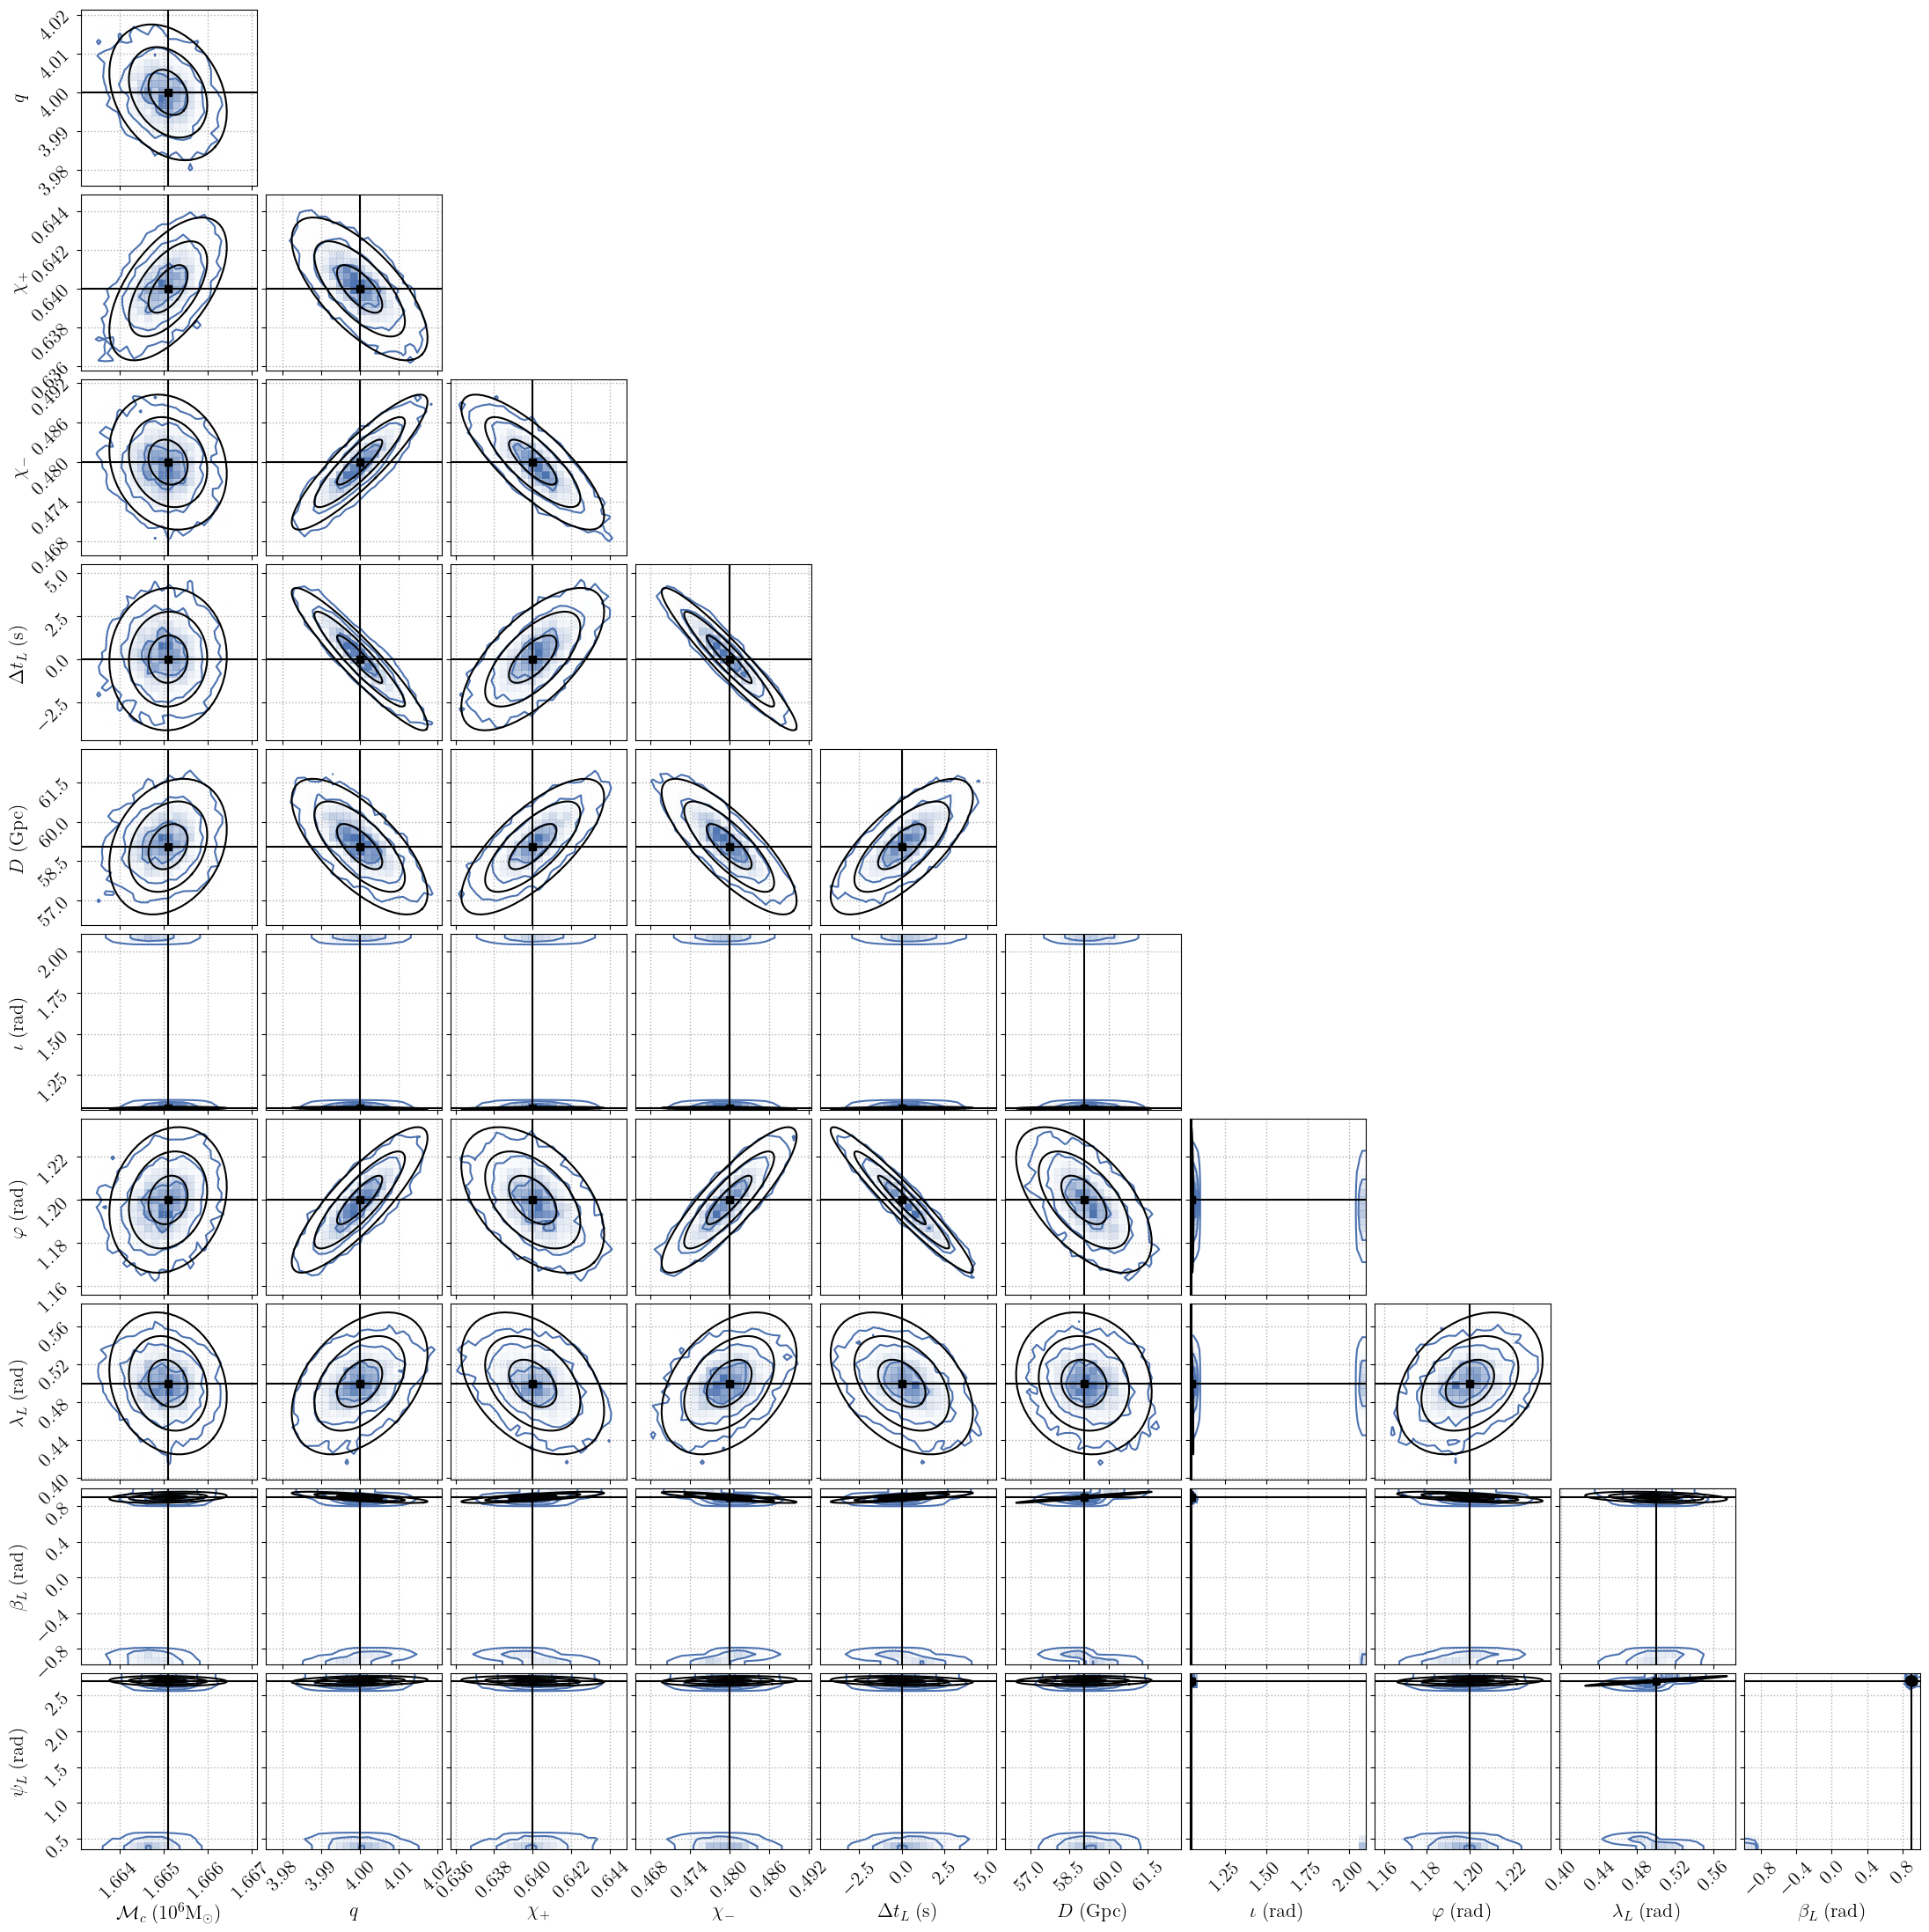

In [27]:
fig = plotutils.corner_plot(params_post['injparams_Lframe'], params_post['post'], output=False, histograms=True, fisher=True, fishercov=params_post['fishercov'], params=['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi'], Lframe=True, color=plotutils.plotpalette[0], cov_color='k', show_truths=True, truth_color='k', bins=25, show_histograms=False, plot_datapoints=False);

In [28]:
Nsamples = params_post['post']['beta'].shape[0]
np.sum(params_post['post']['beta'] > 0) / Nsamples, np.sum(params_post['post']['beta'] < 0) / Nsamples

(0.626578125, 0.373421875)

## A closer look at the multimodal posterior

In [41]:
mask_main = (params_post['post']['beta'] > 0)
post_main = {}
for p in list_params:
     post_main[p] = params_post['post'][p][mask_main]
post_main['lnL'] = params_post['post']['lnL'][mask_main]
post_main['Lframe'] = params_post['post']['Lframe']
post_main = pytools.complete_all_params(post_main)

mask_reflected = (params_post['post']['beta'] < 0)
post_reflected = {}
for p in list_params:
     post_reflected[p] = params_post['post'][p][mask_reflected]
post_reflected['lnL'] = params_post['post']['lnL'][mask_reflected]
post_reflected['Lframe'] = params_post['post']['Lframe']
post_reflected = pytools.complete_all_params(post_reflected)

imax_reflected = np.argmax(params_post['post']['lnL'][mask_reflected])
params_reflected_maxlnL = {}
for p in list_params:
     params_reflected_maxlnL[p] = post_reflected[p][imax_reflected]
params_reflected_maxlnL['Lframe'] = params_post['post']['Lframe']
params_reflected_maxlnL = pytools.complete_all_params(params_reflected_maxlnL)

post_reflected_plt = jump_params_skymode(post_reflected, (-1,0))
params_reflected_maxlnL_plt = jump_params_skymode(params_reflected_maxlnL, (-1,0))

In [42]:
params_reflected_maxlnL_plt = jump_params_skymode(params_reflected_maxlnL, (-1,0))

In [43]:
post_reflected_plt = jump_params_skymode(post_reflected, (-1,0))

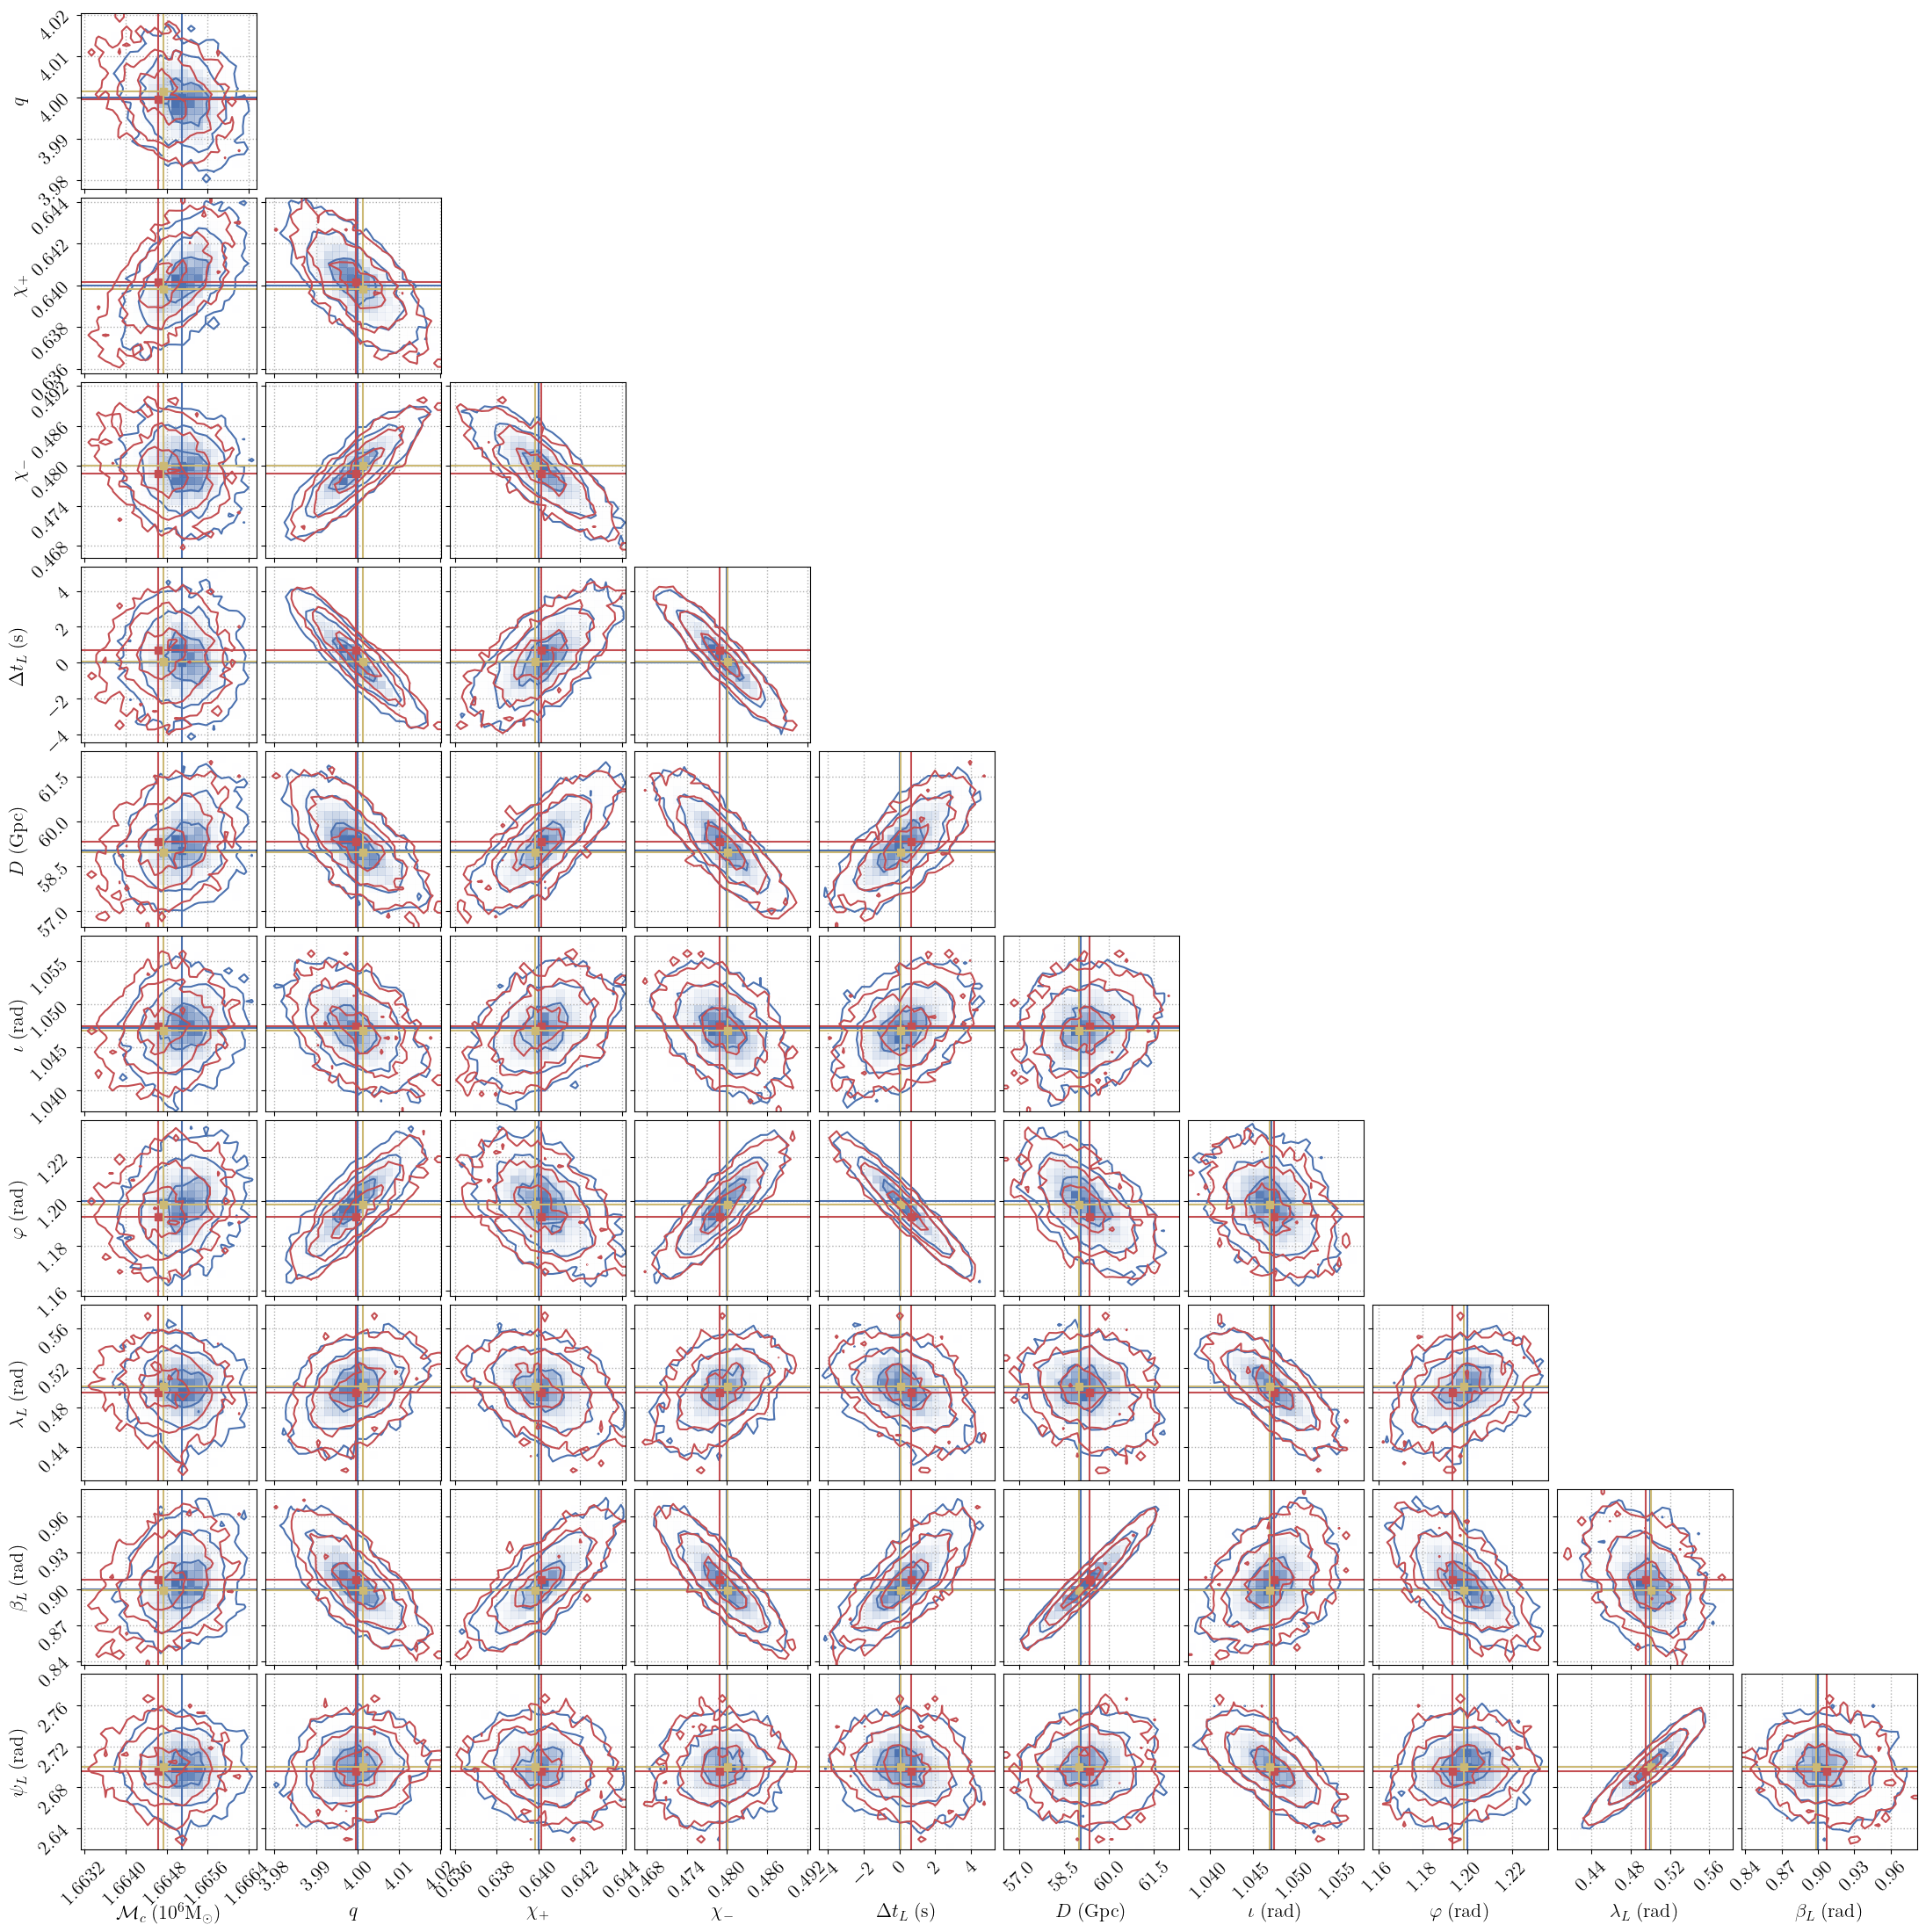

In [82]:
fig = plotutils.corner_plot(params_post['injparams_Lframe'], post_main, output=False, histograms=True, fisher=False, fishercov=None, add_posteriors=[post_reflected_plt], add_truths=[params_reflected_maxlnL_plt], params=list_params, Lframe=True, color=plotutils.plotpalette[0], add_colors=[plotutils.plotpalette[1]], add_truth_colors=[plotutils.plotpalette[1]], cov_color='k', show_truths=True, truth_color=plotutils.plotpalette[0], bins=25, show_histograms=False, plot_datapoints=False);

## Sky modes: going beyond the simple lnL estimate

In [7]:
likelihood = lisa.LikelihoodLISASMBH_LinearResiduals(params,
                                            ref_params=None,
                                            ngrid=128,
                                            data=None, **waveform_params)

In [8]:
lisatools.func_loglikelihood_skymodes(likelihood)

{(1, 0): -4.596185747453702e-27,
 (-1, 0): -1.2194311058899083,
 (1, 1): -526.3235368015313,
 (-1, 1): -526.8530137767534,
 (1, 2): -1047.0896516987298,
 (-1, 2): -1044.921613125887,
 (1, 3): -526.9693989338863,
 (-1, 3): -527.4614198251502}

In [62]:
list_params = ['Mchirp', 'q', 'chip', 'chim', 'Deltat', 'dist', 'inc', 'phi', 'lambda', 'beta', 'psi']

fishercov = lisa_fisher.fisher_covariance_smbh(params, freqs=['nyquist_log', None], list_params=list_params, Lframe=True, **waveform_params)

In [63]:
params_complete = pytools.complete_all_params(params)
scales = np.array([np.sqrt(fishercov['cov'][ip,ip]) for ip,p in enumerate(list_params)])

def pars_from_x(x, ref_params=params_complete):
    pars = dict([(p, ref_params[p] + scales[ip] * x[ip]) for ip,p in enumerate(list_params)]) 
    pars['Lframe'] = True
    return pars

def x_from_pars(pars, ref_params=params_complete):
    return np.array([(pars[p] - ref_params[p]) / scales[ip] for ip,p in enumerate(list_params)])

# This is the function that will be minimized by the Nelder-Mead algorithm.
def f_het(x, ref_params):
    pars = pars_from_x(x, ref_params=ref_params)
    return -likelihood.lnL(pars)

In [64]:
x_inj = x_from_pars(params_complete)

In [77]:
dim = 11
initial_simplex_size = 20

initial_simplex = np.zeros((dim+1,dim), dtype=float)
for i in range(1,dim+1):
    initial_simplex[i,i-1] = initial_simplex_size
    
res_neldermead_inj = scipy.optimize.minimize(f_het, x_inj, params_complete, method='Nelder-Mead', options={'initial_simplex': initial_simplex, 'return_all': True, 'maxiter':20000, 'maxfev':20000})
res_neldermead_inj

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 5.426157748265654e-06
             x: [-5.989e-05 -2.483e-04 -6.886e-04  1.695e-04 -1.982e-04
                 -8.624e-04  6.116e-04 -2.319e-04 -3.119e-04 -6.402e-04
                 -5.678e-04]
           nit: 291
          nfev: 537
 final_simplex: (array([[-5.989e-05, -2.483e-04, ..., -6.402e-04,
                        -5.678e-04],
                       [-6.342e-05, -2.452e-04, ..., -6.669e-04,
                        -5.769e-04],
                       ...,
                       [-8.672e-06, -2.208e-04, ..., -6.119e-04,
                        -5.673e-04],
                       [-4.353e-05, -2.427e-04, ..., -6.328e-04,
                        -5.724e-04]]), array([ 5.426e-06,  6.527e-06,  8.075e-06,  1.672e-05,
                        1.756e-05,  2.811e-05,  4.096e-05,  4.522e-05,
                        4.977e-05,  7.669e-05,  7.745e-05,  9.653e-05]))
       allvecs: [a

In [66]:
def jump_params_skymode(params, skymode):
    if not params.get('Lframe', 'False'):
        raise ValueError('Requires parameters in the L-frame.')
    params_skymode = copy.deepcopy(params)
    skymode_index0, skymode_index1 = skymode
    inc = params['inc']
    lambdaL = params['lambda']
    betaL = params['beta']
    psiL = params['psi']
    params_skymode['inc'] = pytools.modpi(np.pi/2 - (skymode_index0 *(np.pi/2 - inc)))
    params_skymode['lambda'] = pytools.mod2pi(lambdaL + skymode_index1 * np.pi/2)
    params_skymode['beta'] = skymode_index0 * betaL
    params_skymode['psi'] = pytools.modpi(np.pi/2 - (skymode_index0 *(np.pi/2 - psiL)) + skymode_index1 * np.pi/2)
    return params_skymode

In [67]:
params_reflected = jump_params_skymode(params_complete, (-1,0))

In [68]:
x_reflected = x_from_pars(params_reflected, ref_params=params_reflected)

In [69]:
x_reflected

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [78]:
dim = 11
initial_simplex_size = 20

initial_simplex = np.zeros((dim+1,dim), dtype=float)
for i in range(1,dim+1):
    initial_simplex[i,i-1] = initial_simplex_size

res_neldermead_reflected = scipy.optimize.minimize(f_het, x_reflected, params_reflected,  method='Nelder-Mead', options={'initial_simplex': initial_simplex, 'return_all': True, 'maxiter':20000, 'maxfev':20000})
res_neldermead_reflected

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.6346602973933761
             x: [-9.154e-01  2.419e-01 -1.388e-01  2.302e-02  4.604e-02
                 -6.817e-02  6.595e-02 -1.379e-01  4.466e-02  6.257e-02
                 -2.289e-02]
           nit: 584
          nfev: 1231
 final_simplex: (array([[-9.154e-01,  2.419e-01, ...,  6.257e-02,
                        -2.289e-02],
                       [-9.154e-01,  2.419e-01, ...,  6.257e-02,
                        -2.289e-02],
                       ...,
                       [-9.154e-01,  2.419e-01, ...,  6.257e-02,
                        -2.289e-02],
                       [-9.154e-01,  2.419e-01, ...,  6.257e-02,
                        -2.289e-02]]), array([ 6.347e-01,  6.347e-01,  6.347e-01,  6.347e-01,
                        6.347e-01,  6.347e-01,  6.347e-01,  6.347e-01,
                        6.347e-01,  6.347e-01,  6.347e-01,  6.347e-01]))
       allvecs: [arr

In [79]:
params_reflected, pars_from_x(res_neldermead_reflected.x, ref_params=params_reflected)

({'M': 5000000.0,
  'q': 4.0,
  'chi1': 0.7,
  'chi2': 0.4,
  'Deltat': 0.0,
  'dist': 59046.10457286159,
  'inc': 2.0943951023931957,
  'phi': 1.2,
  'lambda': 0.5,
  'beta': -0.9,
  'psi': 0.44159265358979294,
  'Lframe': True,
  'm1': 4000000.0,
  'm2': 1000000.0,
  'Mchirp': 1665106.4148037464,
  'eta': 0.16,
  'chis': 0.55,
  'chia': 0.14999999999999997,
  'chip': 0.6399999999999999,
  'chim': 0.4799999999999999,
  'chiPN': 0.5808141592920354,
  'chi1x': 0.0,
  'chi1y': 0.0,
  'chi1z': 0.7,
  'chi2x': 0.0,
  'chi2y': 0.0,
  'chi2z': 0.4},
 {'Mchirp': 1664736.911937852,
  'q': 4.001405860870854,
  'chip': 0.6398321083307763,
  'chim': 0.4800784636536002,
  'Deltat': 0.0637156409636178,
  'dist': 58987.2189848846,
  'inc': 2.094609058998301,
  'phi': 1.1984503135522744,
  'lambda': 0.5011129179893627,
  'beta': -0.8986912721473181,
  'psi': 0.4410656616751614,
  'Lframe': True})

In [81]:
params_reflected_NM = pars_from_x(res_neldermead_reflected.x, ref_params=params_reflected)
params_reflected_NM = pytools.complete_all_params(params_reflected_NM_plt)

params_reflected_NM_plt = jump_params_skymode(params_reflected_NM, (-1,0))

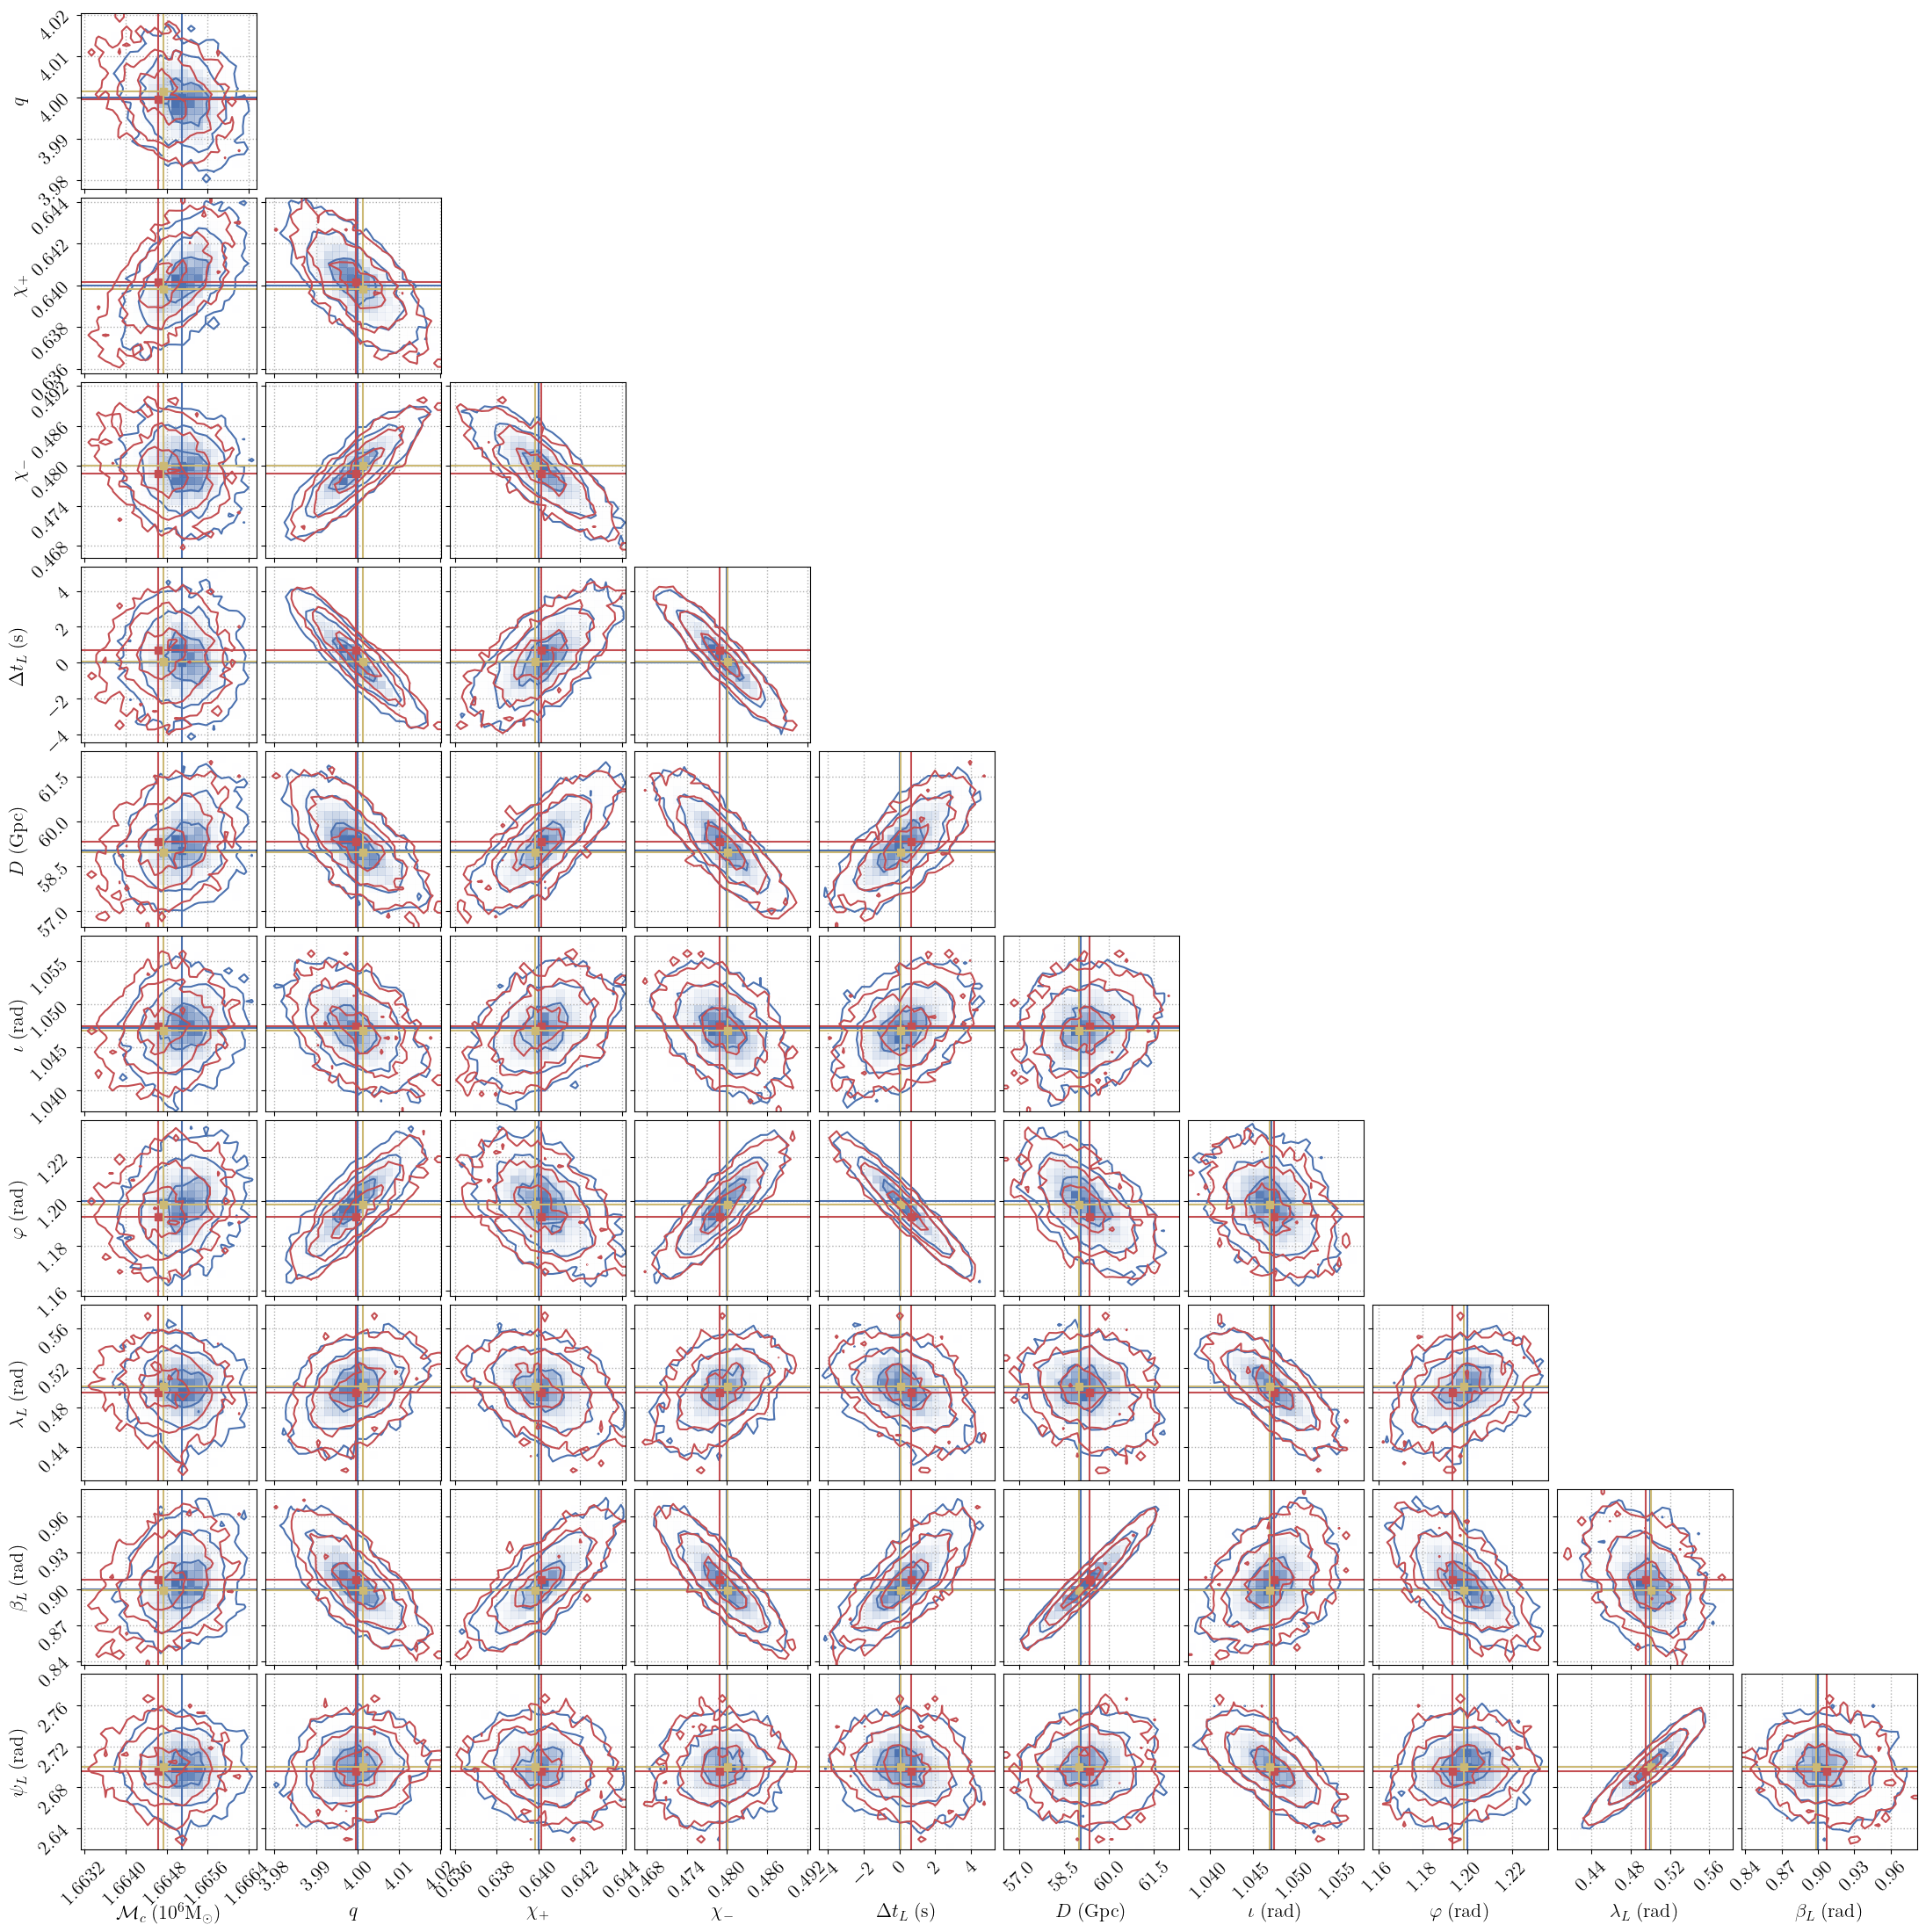

In [82]:
fig = plotutils.corner_plot(params_post['injparams_Lframe'], post_main, output=False, histograms=True, fisher=False, fishercov=None, add_posteriors=[post_reflected_plt], add_truths=[params_reflected_maxlnL_plt, params_reflected_NM_plt], params=list_params, Lframe=True, color=plotutils.plotpalette[0], add_colors=[plotutils.plotpalette[1]], add_truth_colors=[plotutils.plotpalette[1], plotutils.plotpalette[2]], cov_color='k', show_truths=True, truth_color=plotutils.plotpalette[0], bins=25, show_histograms=False, plot_datapoints=False);

In [72]:
params_reflected_maxlnL, pars_from_x(res_neldermead_reflected.x, ref_params=params_reflected)

({'Mchirp': 1664630.6647402013,
  'q': 3.9995744907245645,
  'chip': 0.640142387427839,
  'chim': 0.47888630462065973,
  'Deltat': 0.6850976931856771,
  'dist': 59330.368846862264,
  'inc': 2.0941321390719807,
  'phi': 1.1931583692021053,
  'lambda': 0.4951378520547869,
  'beta': -0.9073633228414009,
  'psi': 0.4453504901049987,
  'Lframe': True,
  'm1': 3998618.9079852165,
  'm2': 999761.0788993773,
  'M': 4998379.986884594,
  'eta': 0.16001021280202118,
  'chi1': 0.6994078140223632,
  'chi2': 0.40310589903847077,
  'chis': 0.5512568565304169,
  'chia': 0.14815095749194615,
  'chiPN': 0.5808175091440124,
  'chi1x': 0.0,
  'chi1y': 0.0,
  'chi1z': 0.6994078140223632,
  'chi2x': 0.0,
  'chi2y': 0.0,
  'chi2z': 0.40310589903847077},
 {'Mchirp': 1665106.3726163795,
  'q': 4.00000008662449,
  'chip': 0.640000198371839,
  'chim': 0.48000010629643347,
  'Deltat': 1.1044267410443274e-07,
  'dist': 59046.12055228213,
  'inc': 2.0943951813797423,
  'phi': 1.2000001810645633,
  'lambda': 0.50000

In [73]:
res_neldermead_reflected.x, -res_neldermead_reflected.fun

(array([-1.04508958e-04,  1.49021659e-05,  1.63978655e-04,  3.11883156e-05,
         7.98025461e-08,  1.84991463e-05,  2.43475254e-05,  1.61178053e-05,
         2.26400255e-05,  3.09535144e-05,  1.33851559e-05]),
 -1.2179994167710102)

In [74]:
np.max(post_reflected['lnL'])

-1.0292445312261953

In [75]:
post_reflected['lnL'][imax_reflected]

-1.0292445312261953

In [76]:
likelihood.lnL(params_reflected), likelihood.lnL(params_reflected_maxlnL)

(-1.2194311058899083, -1.0292445312261953)

In [53]:
pars_from_x(res_neldermead_reflected.x, ref_params=params_reflected), likelihood.lnL(pars_from_x(res_neldermead_reflected.x, ref_params=params_reflected))

({'Mchirp': 1665016.0455105864,
  'q': 4.000000002242854,
  'chip': 0.6400000002719792,
  'chim': 0.4799999998416083,
  'Deltat': -1.9148523752813987e-05,
  'dist': 59045.03261704643,
  'inc': 2.094395103836171,
  'phi': 1.2000000137903986,
  'lambda': 0.49999999995779065,
  'beta': -0.8999999450448112,
  'psi': 0.4415926825940584,
  'Lframe': True},
 -1.0049991443452329)

In [54]:
x_from_pars(params_reflected, ref_params=params_reflected), x_from_pars(params_reflected_maxlnL, ref_params=params_reflected)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-2.91958450e-03, -1.25929200e+01,  9.72940412e+01, -9.58766548e+01,
         3.57694427e-01,  3.80981252e-04, -2.49861060e+01, -5.42131347e+01,
        -7.82981656e+00, -1.68326820e+01,  7.09254374e+00]))

In [59]:
params_reflected_maxlnL['q'] - params_complete['q'], scales[1]

(-0.0004255092754354983, 3.378956394770695e-05)

In [60]:
fishercov['cov'][1,1]

3.378956394770695e-05

In [55]:
params_reflected_maxlnL

{'Mchirp': 1664630.6647402013,
 'q': 3.9995744907245645,
 'chip': 0.640142387427839,
 'chim': 0.47888630462065973,
 'Deltat': 0.6850976931856771,
 'dist': 59330.368846862264,
 'inc': 2.0941321390719807,
 'phi': 1.1931583692021053,
 'lambda': 0.4951378520547869,
 'beta': -0.9073633228414009,
 'psi': 0.4453504901049987,
 'Lframe': True,
 'm1': 3998618.9079852165,
 'm2': 999761.0788993773,
 'M': 4998379.986884594,
 'eta': 0.16001021280202118,
 'chi1': 0.6994078140223632,
 'chi2': 0.40310589903847077,
 'chis': 0.5512568565304169,
 'chia': 0.14815095749194615,
 'chiPN': 0.5808175091440124,
 'chi1x': 0.0,
 'chi1y': 0.0,
 'chi1z': 0.6994078140223632,
 'chi2x': 0.0,
 'chi2y': 0.0,
 'chi2z': 0.40310589903847077}

In [ ]:
itest = imax_reflected
params_test = {}
for p in list_params:
    params_test[p] = params_post['post'][p][mask_reflected][itest]
params_test['Lframe'] = True

likelihood.lnL(params_test), params_post['post']['lnL'][mask_reflected][itest]

In [ ]:
params_reflected_maxlnL, params_test

In [83]:
Nsamples = params_post['post']['beta'].shape[0]
np.sum(params_post['post']['beta'] > 0) / Nsamples, np.sum(params_post['post']['beta'] < 0) / Nsamples

(0.626578125, 0.373421875)

In [88]:
likelihood.lnL(params_reflected), likelihood.lnL(params_reflected_maxlnL), likelihood.lnL(params_reflected_NM)

(-1.2194311058899083, -1.0292445312261953, -0.6346602973933761)

In [89]:
np.exp(likelihood.lnL(params_reflected)) / (1 + np.exp(likelihood.lnL(params_reflected))), np.exp(likelihood.lnL(params_reflected_maxlnL)) / (1 + np.exp(likelihood.lnL(params_reflected_maxlnL))), np.exp(likelihood.lnL(params_reflected_NM)) / (1 + np.exp(likelihood.lnL(params_reflected_NM)))

(0.22803658086442644, 0.26323059375829233, 0.3464545818446166)

In [103]:
np.sqrt(np.linalg.det(fishercov['cov'])), np.sqrt(np.linalg.det(np.cov(np.array([post_main[p] for p in list_params])))), np.sqrt(np.linalg.det(np.cov(np.array([post_reflected[p] for p in list_params]))))

(3.8186495148712225e-18, 4.071624583745425e-18, 4.3946105048882236e-18)

In [99]:
def p_multi_gaussian(lambdas, detSigmas):
    p0 = 1. / np.sum([np.sqrt(detSigmas[k] / detSigmas[0]) * np.exp(-lambdas[k]) for k in range(len(lambdas))])
    pks = np.array([p0 * np.sqrt(detSigmas[k] / detSigmas[0]) * np.exp(-lambdas[k]) for k in range(len(lambdas))])
    return pks

In [100]:
detSigmas = [np.linalg.det(np.cov(np.array([post_main[p] for p in list_params]))), np.linalg.det(np.cov(np.array([post_reflected[p] for p in list_params])))]

In [102]:
p_multi_gaussian([0., -likelihood.lnL(params_reflected)], detSigmas), p_multi_gaussian([0., -likelihood.lnL(params_reflected_maxlnL)], detSigmas), p_multi_gaussian([0., -likelihood.lnL(params_reflected_NM)], detSigmas)

(array([0.7582473, 0.2417527]),
 array([0.72169957, 0.27830043]),
 array([0.63606454, 0.36393546]))

# Where does the sky localization information come from ? Exploring response approximations 

## TDI transfer functions

In [139]:
approx_list = ['frozen-lowf', 'lowf', 'frozen', 'full']

def waveform_params_approx(waveform_params, approx):
    waveform_params_approx = copy.deepcopy(waveform_params)
    if approx=='frozen-lowf':
        waveform_params_approx['frozenLISA'] = True
        waveform_params_approx['responseapprox'] = 'lowfL'
    elif approx=='lowf':
        waveform_params_approx['frozenLISA'] = False
        waveform_params_approx['responseapprox'] = 'lowfL'
    elif approx=='frozen':
        waveform_params_approx['frozenLISA'] = True
        waveform_params_approx['responseapprox'] = 'full'
    elif approx=='full':
        waveform_params_approx['frozenLISA'] = False
        waveform_params_approx['responseapprox'] = 'full'
    else:
        raise ValueError('approx not recognized.')
    return waveform_params_approx

In [148]:
params = {
    # Total *redshifted* mass M=m1+m2, solar masses
    "M": 5e6,
    # Mass ratio q=m1/m2
    "q": 4.0,
    # Dimensionless spin component 1 along orbital momentum
    "chi1": 0.7,
    # Dimensionless spin component 2 along orbital momentum
    "chi2": 0.4,
    # Time shift of coalescence, s -- coalescence is at t0*yr + Deltat*s, t0 in waveform_params
    "Deltat": 0.0,
    # Luminosity distance, Mpc
    "dist": cosmo.luminosity_distance(1.).value,
    # Inclination, observer's colatitude in source-frame
    "inc": 1.0471975511965976,
    # Phase, observer's longitude in source-frame
    "phi": 1.2,
    # Longitude in the sky
    "lambda": 0.5,
    # Latitude in the sky
    "beta": 0.9,
    # Polarization angle
    "psi": 2.7,
    # Flag indicating whether angles and Deltat pertain to the L-frame or SSB-frame
    "Lframe": True
  }

In [149]:
# Parameters for the waveform generation and other options

waveform_params = {
    # Frequency range
    "minf": 1e-5,
    "maxf": 0.5,
    # Reference epoch of coalescence, yr -- coalescence is at t0*yr + Deltat*s, Deltat in params
    "t0": 0.0,
    # Always cut signals timetomerger_max*yr before merger -- to avoid needlessly long signals using minf
    "timetomerger_max": 2.0,
    # Option to cut the signal pre-merger -- must be in L-frame
    "DeltatL_cut": None,
    # Further options to cut signals
    "fstart22": None,
    "fend22": None,
    "tmin": None,
    "tmax": None,
    # TDI channels to generate
    "TDI": "TDIAET",
    # Internal accuracy params
    "order_fresnel": 0,
    # Waveform approximant and set of harmonics to use
    "approximant": "IMRPhenomXHM",
    "modes": None,
    # LISA response options
    "LISAconst": "Proposal",
    "responseapprox": "full",
    "frozenLISA": False,
    "TDIrescaled": True,
    # Noise options -- can also be given as a numpy array for interpolation
    "LISAnoise": {
        "InstrumentalNoise": "SciRDv1",
        "WDbackground": True,
        "WDduration" : 4.0,
        "lowf_add_pm_noise_f0": 0.0,
        "lowf_add_pm_noise_alpha": 2.0
    }
  }

In [150]:
M_list = ['M1e5', 'M1e7']

def params_of_M(Mstr):
    params_M = copy.deepcopy(params)
    params_M['M'] = float(Mstr[1:])
    return params_M

In [151]:
wftdi = {}
for Mstr in M_list:
    wftdi[Mstr] = {}
    for approx in approx_list:
        wftdi[Mstr][approx] = lisa.GenerateLISATDI_SMBH(params_of_M(Mstr), **waveform_params_approx(waveform_params, approx))

/Users/marsat/miniconda3/envs/lal-py312/lib/python3.12/site-packages/lisabeta/utils/plotutils.py:120: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  f = plt.figure(0, figsize=size)


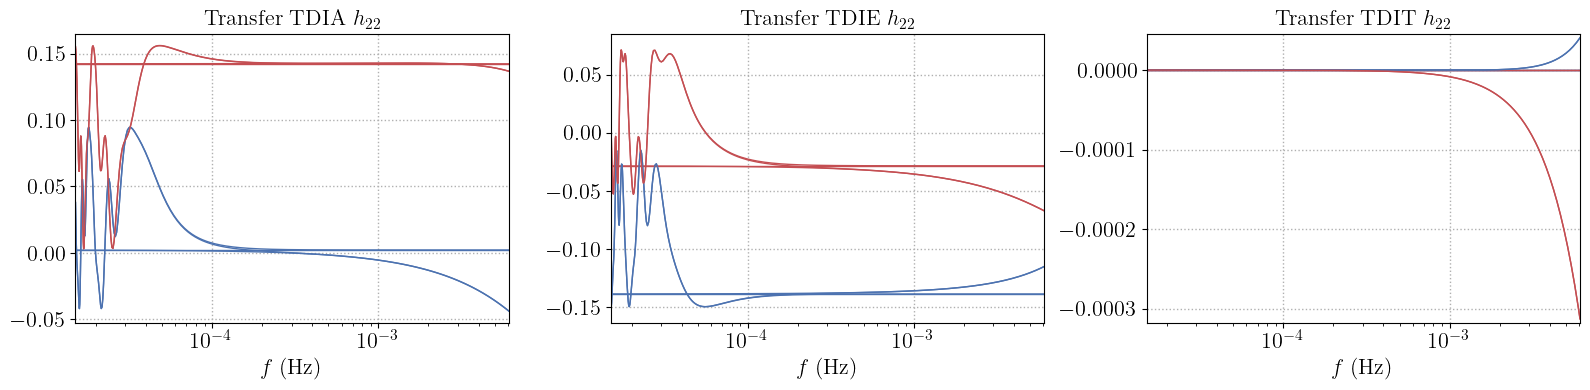

<Figure size 800x400 with 0 Axes>

In [142]:
Mstr = 'M1e7'

# Transfer functions, mode h22 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{22}$', 'Transfer TDIE $h_{22}$', 'Transfer TDIT $h_{22}$']
lm = (2,2)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[Mstr][approx][(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    for approx in approx_list:
        plotutils.lloglinearplot(axs[i], [wftdi[Mstr][approx][lm]['freq'], np.real(wftdi[Mstr][approx][lm][transferstr]) * rescaling], [wftdi[Mstr][approx][lm]['freq'], np.imag(wftdi[Mstr][approx][lm][transferstr]) * rescaling])
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_title(r'' + titles[i])
fig.tight_layout()

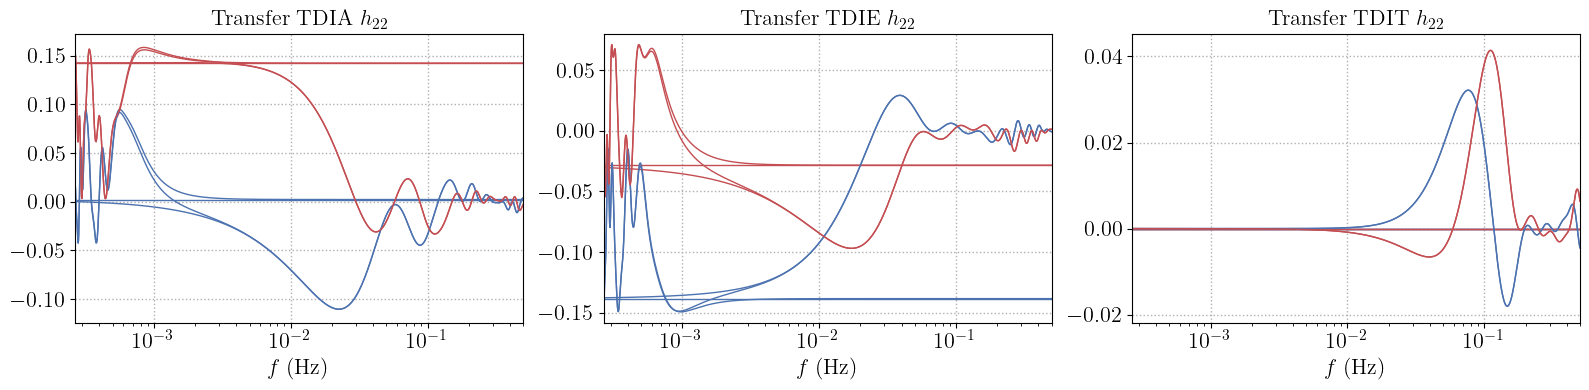

<Figure size 800x400 with 0 Axes>

In [144]:
Mstr = 'M1e5'

# Transfer functions, mode h22 (NOTE: rescaled by (6*pi*f*L/c))
titles = ['Transfer TDIA $h_{22}$', 'Transfer TDIE $h_{22}$', 'Transfer TDIT $h_{22}$']
lm = (2,2)

L = 2.5e9
rescaling = 1./(6*np.pi*wftdi[Mstr][approx][(2,2)]['freq']*L/pyconstants.C_SI)

fig, axs = plt.subplots(1,3, figsize=[16,4])
for i in range(3):
    transferstr = 'transferL' + str(i+1)
    for approx in approx_list:
        plotutils.lloglinearplot(axs[i], [wftdi[Mstr][approx][lm]['freq'], np.real(wftdi[Mstr][approx][lm][transferstr]) * rescaling], [wftdi[Mstr][approx][lm]['freq'], np.imag(wftdi[Mstr][approx][lm][transferstr]) * rescaling])
    axs[i].set_xlabel(r'$f \; (\mathrm{Hz})$')
    axs[i].set_title(r'' + titles[i])
fig.tight_layout()

## Fisher sky localization

In [152]:
fishercov = {}
sky_area = {}
for Mstr in M_list:
    fishercov[Mstr] = {}
    sky_area[Mstr] = {}
    for approx in approx_list:
        fishercov[Mstr][approx] = lisa_fisher.fisher_covariance_smbh(params_of_M(Mstr), freqs=['nyquist_log', None], steps=None, list_params=list_params, Lframe=True, **waveform_params_approx(waveform_params, approx))
        sky_area[Mstr][approx] = lisatools.sky_area_cov(fishercov[Mstr][approx], sq_deg=True, n_sigma=None, prob=0.90)

In [153]:
sky_area

{'M1e5': {'frozen-lowf': 332.9048753951892,
  'lowf': 39.54650216975393,
  'frozen': 24.30448829236197,
  'full': 15.897417377671857},
 'M1e7': {'frozen-lowf': 0.46560916140887115,
  'lowf': 0.4666396938525019,
  'frozen': 0.2870095280701382,
  'full': 0.28736631418923764}}

## Sky multimodality degeneracies

In [154]:
lnL_skymodes = {}
for Mstr in M_list:
    lnL_skymodes[Mstr] = {}
    for approx in approx_list:
        likelihood = lisa.LikelihoodLISASMBH(params_of_M(Mstr), **waveform_params_approx(waveform_params, approx))
        lnL_skymodes[Mstr][approx] = lisatools.func_loglikelihood_skymodes(likelihood)

In [155]:
lnL_skymodes

{'M1e5': {'frozen-lowf': {(1, 0): 8.731149137020111e-11,
   (-1, 0): 2.6193447411060333e-10,
   (1, 1): 1.3096723705530167e-10,
   (-1, 1): 2.473825588822365e-10,
   (1, 2): 1.8917489796876907e-10,
   (-1, 2): 2.9103830456733704e-11,
   (1, 3): 4.802132025361061e-10,
   (-1, 3): 4.94765117764473e-10},
  'lowf': {(1, 0): 5.820766091346741e-11,
   (-1, 0): -366.7976689962816,
   (1, 1): -328.0857738982595,
   (-1, 1): -654.355157781858,
   (1, 2): -2400.6333630871814,
   (-1, 2): -989.6240854363132,
   (1, 3): -2498.20385510262,
   (-1, 3): -2803.5512354723323},
  'frozen': {(1, 0): -2.9103830456733704e-11,
   (-1, 0): 7.275957614183426e-11,
   (1, 1): -1056.9519940137106,
   (-1, 1): -1056.951994013696,
   (1, 2): -1573.6305645488028,
   (-1, 2): -1573.6305645488173,
   (1, 3): -996.759864374646,
   (-1, 3): -996.7598643746023},
  'full': {(1, 0): 2.9103830456733704e-11,
   (-1, 0): -367.5287102245784,
   (1, 1): -1344.8660137633706,
   (-1, 1): -1646.664778592196,
   (1, 2): -4065.8189